# Preparation

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import ScaledTranslation
from h5netcdf import File
from eigen_microstate import *
from lgmr_em import data_utils, plot_utils
%matplotlib inline

In [2]:
plt.rcParams["font.family"] = "Arial"
plt.rcParams["savefig.format"] = "pdf"
plt.rcParams["figure.constrained_layout.use"] = True
plt.rcParams["legend.frameon"] = False
plt.rcParams["savefig.bbox"] = "tight"

In [3]:
lgmr_general_path = "data/LGMR/LGMR_{}_climo.nc"
trace_general_path = "data/TraCE/TraCE-21K-II.ann.{}.nc"
varnames = ("SAT", "SST", "d18Op")
n_top = 4
figsize = (30, 32)
dpi = 240

# Plot Global Mean Surface Temperature Series

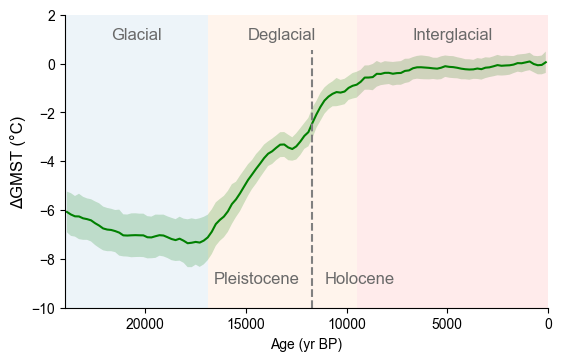

In [4]:
file = lgmr_general_path.format("GMST")
with File(file, "r", decode_vlen_strings=True) as f:
    gmst = f["gmst"][...]
    gmst_std = f["gmst_std"][...]
    age = f["age"][...]

gmst_2k = gmst[age <= 2000].mean()
delta_gmst = gmst - gmst_2k

fig, ax = plt.subplots(figsize=(5.5, 3.5))
plot_utils.plot_evolution_series(
    age,
    delta_gmst,
    ax=ax,
    xlabel="Age (yr BP)",
    ylabel="ΔGMST (°C)",
    color="green",
    label="LGMR",
)
ax.fill_between(
    age, delta_gmst - 2 * gmst_std, delta_gmst + 2 * gmst_std, fc="green", alpha=0.2
)
ax.set_ylim(-10, 2)
ax.set_xlim(24000, 0)

for x_range, phase, fill_color in zip(
    (
        [24000, data_utils.GLACIAL_DEGLACIAL_BOUNDARY],
        [
            data_utils.GLACIAL_DEGLACIAL_BOUNDARY,
            data_utils.DEGLACIAL_INTERGLACIAL_BOUNDARY,
        ],
        [data_utils.DEGLACIAL_INTERGLACIAL_BOUNDARY, 0],
    ),
    data_utils.LGMR_PHASES,
    ("C0", "C1", "red"),
):
    ax.fill_between(
        x_range, 0, 1, fc=fill_color, alpha=0.08, transform=ax.get_xaxis_transform()
    )
    ax.text(
        sum(x_range) / 2,
        1,
        phase.capitalize(),
        ha="center",
        size="large",
        color="dimgray",
    )

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.axvline(data_utils.HOLOCENE_BOUNDARY, color="gray", linestyle="--", ymax=0.88)
ax.text(
    0.4 * 24000 + 0.6 * data_utils.HOLOCENE_BOUNDARY,
    -9,
    "Pleistocene",
    ha="left",
    size="large",
    color="dimgray",
)
ax.text(
    0.65 * data_utils.HOLOCENE_BOUNDARY + 0.35 * 0,
    -9,
    "Holocene",
    ha="right",
    size="large",
    color="dimgray",
)
# ax.legend(loc="lower right")
fig.savefig("images/LGMR_GMST.pdf")

In [ ]:
trace_TS = xr.open_dataarray(trace_general_path.format("TS"))
weights = np.cos(np.deg2rad(trace_TS.lat))
weights.name = "weights"

trace_TS = trace_TS.weighted(weights)
TS_mean = trace_TS.mean(("lat", "lon"))
TS_mean.coords["time"] = TS_mean.time * (-1000)
TS_mean = TS_mean[TS_mean.time >= 0]
TS_mean -= 273.15
TS_mean_2k = np.mean(TS_mean[TS_mean.time <= 2000].values)
delta_TS = TS_mean - TS_mean_2k

plot_utils.plot_evolution_series(
    delta_TS.time,
    delta_TS,
    ax=ax,
    invert_x=False,
    color="C3",
    label="TraCE-21K-II",
)

ax.legend(loc="lower right", frameon=False);

# Load LGMR Data as Dict

```python
{"SAT": GeospatialRaster, "SST": GeospatialRaster, ...}
```

In [5]:
lgmr = {
    varname: data_utils.load_lgmr_data(
        lgmr_general_path.format(varname), varname=data_utils.LGMR_VAR_KEYS[varname]
    )
    for varname in varnames
}

# Plot the the average and std of temperature

In [ ]:
supfig = plt.figure(figsize=(15,4.5),layout="constrained")
figs = supfig.subfigures(1, len(data_utils.LGMR_PHASES))
for i, phase in enumerate(data_utils.LGMR_PHASES):
    # Select data for this phase
    lgmr_slice = {k: data_utils.lgmr_dataslice(v, phase) for k, v in lgmr.items()}

    fig = figs[i]
    fig.suptitle(f"LGMR {phase.capitalize()}", fontsize="xx-large", fontweight="bold")
    subfigs = fig.subfigures(len(lgmr_slice), 1)
    for (var_name, lgmr_slice), subfig in zip(lgmr_slice.items(), subfigs):
        subfig.subplots(
            1, 2, subplot_kw={"projection": ccrs.Robinson(central_longitude=180)}
        )
        data_mean = lgmr_slice.values.mean(axis=0)
        data_std = lgmr_slice.values.std(axis=0)
        lon, lat = lgmr_slice.lon, lgmr_slice.lat
        plot_utils.plot_2d_raster(
            data_mean,
            lon,
            lat,
            ax=subfig.axes[0],
            cmap="RdBu_r",
            vmin=np.nanmin(data_mean),
            vmax=np.nanmax(data_mean),
            title=f"{var_name} mean",
        )
        plot_utils.plot_2d_raster(
            data_std,
            lon,
            lat,
            ax=subfig.axes[1],
            cmap="Reds",
            vmin=np.nanmin(data_std),
            vmax=np.nanmax(data_std),
            title=f"{var_name} std",
        )

plt.savefig(f"images/LGMR_stats.pdf")

# Plot Eigen Microstates

In [ ]:
n_top = 4
figsize = (14, 8.6)
for phase in data_utils.LGMR_PHASES:
    lgmr_slice = {k: data_utils.lgmr_dataslice(v, phase) for k, v in lgmr.items()}
    ems = {
        k: eigen_microstate_geospatial(v, rescale=True) for k, v in lgmr_slice.items()
    }
    fig = plt.figure(figsize=figsize, layout="compressed")
    fig.suptitle(f"LGMR {phase.capitalize()}", fontsize="xx-large", fontweight="bold")
    plotter = plot_utils.MultiVarEMPlot(len(varnames))
    plotter.plot(ems, n_top, uvwidthratios=[1,0.5], uvspacing=0)
    plt.savefig(f"images/LGMR_EM_{phase}.pdf")

# Top 2 EMs for Interglacial for manuscript

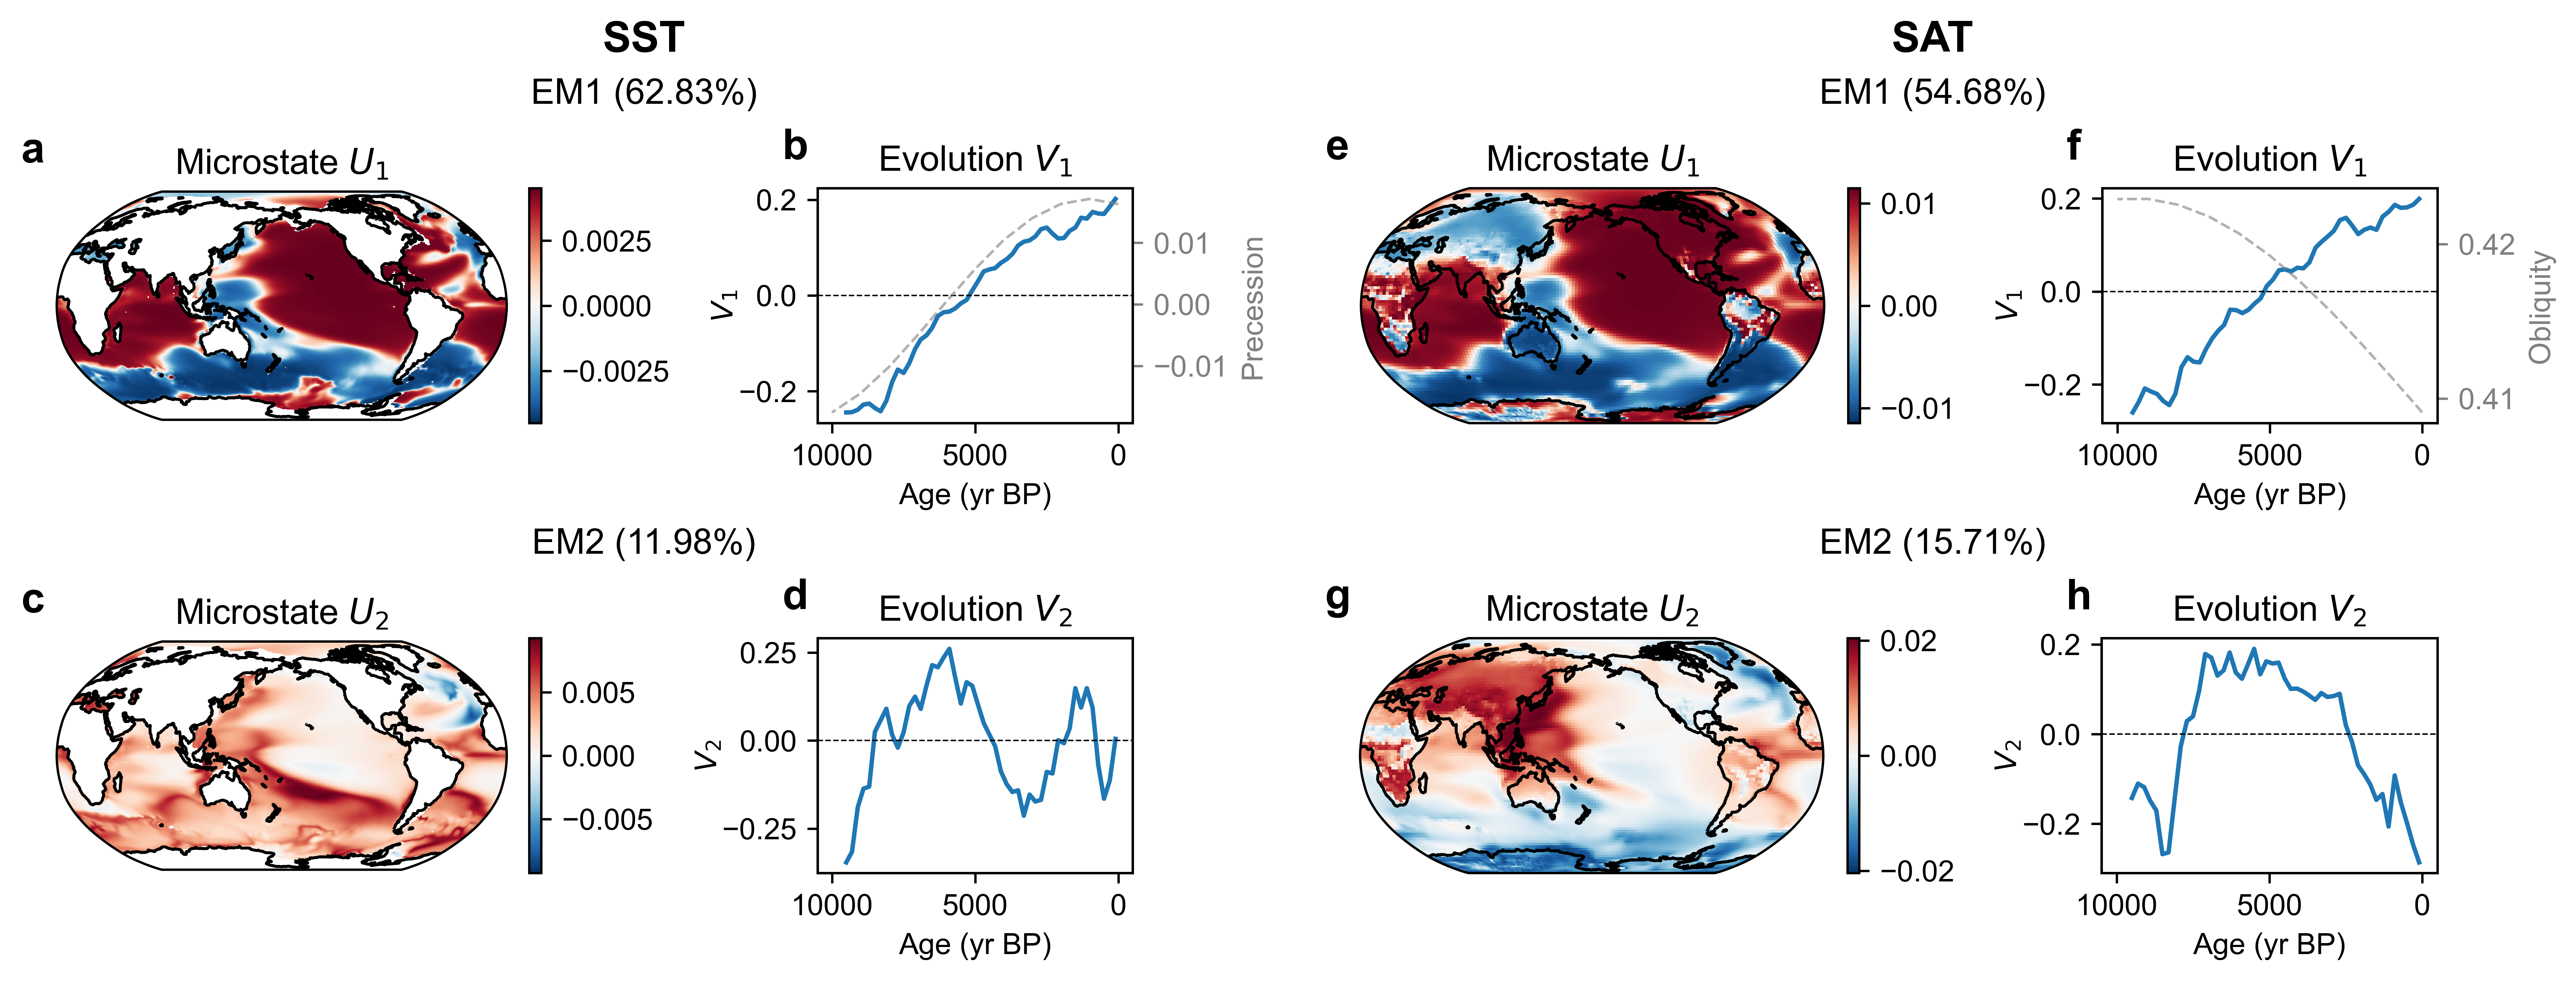

In [6]:
phase = "interglacial"
lgmr_slice = {k: data_utils.lgmr_dataslice(v, phase) for k, v in lgmr.items()}
ems = {
    k: eigen_microstate_geospatial(v, rescale=True) for k, v in lgmr_slice.items()
}
var_names = ["SST", "SAT"]
ems = {k: ems[k] for k in var_names}
fig = plt.figure(
    figsize=(12, 4.5),
    layout="compressed",
    dpi=600,
)
# fig.suptitle(f"LGMR {phase.capitalize()}", fontsize="xx-large", fontweight="bold")
plotter = plot_utils.MultiVarEMPlot(len(var_names))
plotter.plot(ems, title_fmt="{}",n_top=2)

import itertools
from matplotlib.transforms import ScaledTranslation

indices = [f"{l}" for l in "abcdefgh"]

for i, j, k in itertools.product(range(2), repeat=3):
    ax = fig.subfigs[i].subfigs[j].axes[k]
    ax.text(
        0.0,
        1.0,
        indices.pop(0),
        transform=(
            ax.transAxes + ScaledTranslation(-12 / 72, +7 / 72, fig.dpi_scale_trans)
        ),
        fontsize="x-large",
        va="bottom",
        fontweight="bold",
    )

precession = np.loadtxt("data/Orbital/La2004-Precession-0-24.txt")[:11, :]
precession_time = precession[:, 0] * 1000
precession_values = precession[:, 1]

obliquity = np.loadtxt("data/Orbital/La2004-Obliquity-0-24.txt")[:11, :]
obliquity_time = obliquity[:, 0] * 1000
obliquity_values = obliquity[:, 1]


for i in range(2):
    for j in range(2):
        ax = fig.subfigs[i].subfigs[j].axes[1]
        ax_twin = ax.twinx()
        orbital_color = "gray" if j == 0 else "none"
        if i == 0:
            orbital_title = "Precession"
            orbital_time = precession_time
            orbital_values = precession_values
        else:
            orbital_title = "Obliquity"
            orbital_time = obliquity_time
            orbital_values = obliquity_values
        ax_twin.set_ylabel(orbital_title, color=orbital_color)
        ax_twin.plot(orbital_time, orbital_values, color=orbital_color, linestyle="--", alpha=0.6, linewidth=0.9)
        ax_twin.tick_params(axis="y", labelcolor=orbital_color, color=orbital_color)

#fig.savefig("images/LGMR_interglacial.pdf")

# Plot the first Interglacial SST eigen microstate and the trends of proxies

In [ ]:
# Plot the first eigen microstate of Interglacial SST
phase = "interglacial"
projection = ccrs.Robinson(central_longitude=180)
sst = lgmr["SST"]
sst_slice = data_utils.lgmr_dataslice(sst, phase)
em = eigen_microstate_geospatial(sst_slice, rescale=True)
first_order_pattern = em.microstates_[0]

fig = plt.figure(
    figsize=(12, 5.85),
    constrained_layout=False,
)

gs = fig.add_gridspec(1, 2, width_ratios=[11.7, 0.3], wspace=0.02)
ax = fig.add_subplot(gs[0], projection=projection)
cbar_ax = fig.add_subplot(gs[1])

fig.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02)

plot_utils.plot_2d_raster(
    first_order_pattern,
    sst_slice.lon,
    sst_slice.lat,
    ax=ax,
    coastlines=False,
    colorbar=False,
)
ax.coastlines(linewidth=0.5)

cmap = sns.diverging_palette(130, 310, s=95, l=60, as_cmap=True)
proxy_trends = data_utils.proxy_trends("data/LGMR/proxyDatabase.nc")
proxy_trends_plot = plot_utils.ProxyTrendsMap(
    fig=fig,
    mesh_ax=ax,
    ax_crs=projection,
    data_crs=ccrs.PlateCarree(),
    cmap=cmap,
    cbar_ax=cbar_ax,
)
proxy_trends_plot.plot(proxy_trends, explode=40000, radius=350000)

ax.text(
    0.0,
    1.0,
    "i",
    transform=(ax.transAxes + ScaledTranslation(+6 / 72, -6 / 72, fig.dpi_scale_trans)),
    fontsize="x-large",
    va="bottom",
    fontweight="bold",
)
ax.text(
    0.90,
    0.95,
    "Warming",
    transform=(ax.transAxes + ScaledTranslation(+0 / 72, -0 / 72, fig.dpi_scale_trans)),
    fontsize="xx-large",
    va="bottom",
    fontweight="bold",
    color=cmap(0.99),
)

ax.text(
    0.91,
    0.01,
    "Cooling",
    transform=(ax.transAxes + ScaledTranslation(+0 / 72, -0 / 72, fig.dpi_scale_trans)),
    fontsize="xx-large",
    va="bottom",
    fontweight="bold",
    color=cmap(0.01),
);
fig.savefig("images/interglacial_1st_pattern_vs_proxies.pdf")
# The figure may not show correctly in the notebook, but it will be saved correctly

# Insolation

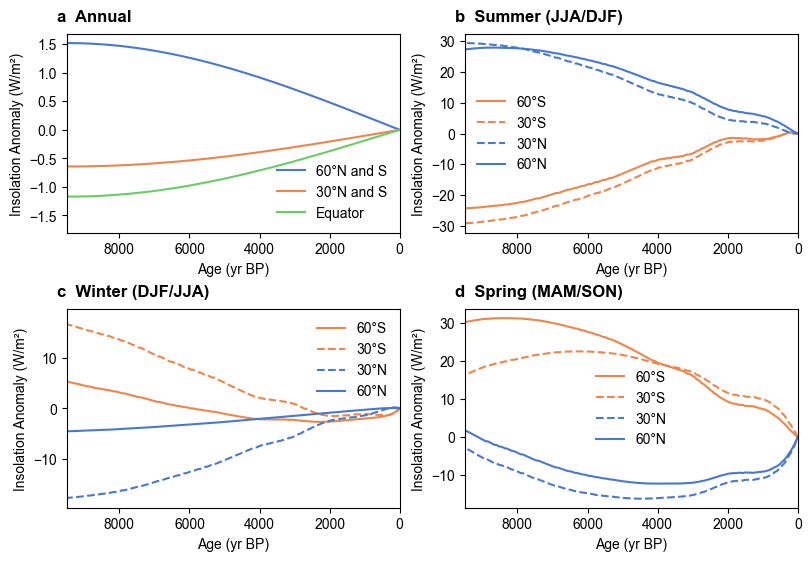

In [7]:
import seaborn as sns

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2,
    2,
    figsize=(8, 5.5),
    subplot_kw={
        "xlim": (9500, 0),
        "ylabel": "Insolation Anomaly (W/m²)",
        "xlabel": "Age (yr BP)",
    },
)

colors = sns.color_palette("muted")

for ax in fig.axes:
    ax.set_prop_cycle(color=colors)


def load_insolation_data(path):
    insolation = np.loadtxt(path)
    insolation_time = insolation[:, 0]
    insolation_anomaly = insolation[:, 1]
    insolation_anomaly = insolation_anomaly - insolation_anomaly[-1]
    return insolation_time, insolation_anomaly


# Annual
for lat, label in zip((60, 30, 0), ("60°N and S", "30°N and S", "Equator")):
    insolation_time, insolation_anomaly = load_insolation_data(
        f"data/Orbital/Insol-t-0-24000yr-day-1-365-lat-({lat})-meandaily-La04.txt"
    )

    ax1.plot(insolation_time, insolation_anomaly, label=label)

# Summer JJA/DJF
for lat, label in zip((-60, -30, 30, 60), ("60°S", "30°S", "30°N", "60°N")):
    days = "152-243" if lat>0 else "335-427"
    insolation_time, insolation_anomaly = load_insolation_data(
        f"data/Orbital/Insol-t-0-24000yr-day-{days}-lat-({lat})-meandaily-La04.txt"
    )
    color = colors[0] if lat > 0 else colors[1]
    linestyle = "--" if abs(lat) < 45 else "-"
    ax2.plot(insolation_time, insolation_anomaly, color=color, linestyle=linestyle, label=label)

# Winter DJF/JJA
for lat, label in zip((-60, -30, 30, 60), ("60°S", "30°S", "30°N", "60°N")):
    days = "335-427" if lat>0 else "152-243"
    insolation_time, insolation_anomaly = load_insolation_data(
        f"data/Orbital/Insol-t-0-24000yr-day-{days}-lat-({lat})-meandaily-La04.txt"
    )
    color = colors[0] if lat > 0 else colors[1]
    linestyle = "--" if abs(lat) < 45 else "-"
    ax3.plot(insolation_time, insolation_anomaly, color=color, linestyle=linestyle, label=label)

# Spring MAM/SON

for lat, label in zip((-60, -30, 30, 60), ("60°S", "30°S", "30°N", "60°N")):
    days = "60-151" if lat>0 else "244-335"
    insolation_time, insolation_anomaly = load_insolation_data(
        f"data/Orbital/Insol-t-0-24000yr-day-{days}-lat-({lat})-meandaily-La04.txt"
    )
    color = colors[0] if lat > 0 else colors[1]
    linestyle = "--" if abs(lat) < 45 else "-"
    ax4.plot(insolation_time, insolation_anomaly, color=color, linestyle=linestyle, label=label)

for ax, label in zip((ax1, ax2, ax3, ax4), ("a  Annual", "b  Summer (JJA/DJF)", "c  Winter (DJF/JJA)", "d  Spring (MAM/SON)")):
    ax.legend()
    ax.text(
        0.0,
        1.0,
        label,
        transform=(ax.transAxes + ScaledTranslation(-7 / 72, +7 / 72, fig.dpi_scale_trans)),
        fontsize="large",
        va="bottom",
        fontweight="bold",
    )

fig.savefig("images/insolation.pdf")

# EOF of LGMR

In [ ]:
n_top = 4
figsize = (30, 13)
dpi = 240

for phase in data_utils.LGMR_PHASES:
    lgmr_slice = {k: data_utils.lgmr_dataslice(v, phase) for k, v in lgmr.items()}
    eofs = {k: get_eofs_as_emg(v, n_top) for k, v in lgmr_slice.items()}
    fig = plt.figure(figsize=figsize, dpi=dpi, constrained_layout=True)
    fig.suptitle(f"LGMR {phase.capitalize()}", fontsize="xx-large", fontweight="bold")
    plotter = plot_utils.MultiVarEMPlot(len(varnames))
    plotter.plot(
        eofs,
        n_top,
        title_fmt="EOF of {}",
        ylabel_fmt="PC{}",
        vtitle_fmt="PC{}",
        utitle_fmt="EOF{}",
        uvspacing=0,
    )